# Module assignment: From Text to Network with LLMs

##### Question: How can a Large Language Model be used to extract structured information from a text corpus and, through the construction and analysis of a related network, identify the central actors, themes, and patterns within the material?

# 1. Environment Setup

In [93]:
# --- ENV + sanity ---
from dotenv import load_dotenv
load_dotenv(override=True)

import os, sys
os.makedirs("outputs", exist_ok=True)

print("Kernel:", sys.executable)
print("GOOGLE_API_KEY set?", os.getenv("GOOGLE_API_KEY") is not None)

# Use a model you have access to
os.environ.setdefault("LLM_MODEL", "models/gemini-2.5-flash")
print("LLM model:", os.getenv("LLM_MODEL"))

print("outputs/ ready.")



Kernel: /Users/nielsandersen/Desktop/Natural_Language_Processing_and_Nework_Analysis/eksamen/.venv/bin/python
GOOGLE_API_KEY set? True
LLM model: models/gemini-2.5-flash
outputs/ ready.


In [94]:
import os, google.generativeai as genai
genai.configure(api_key=os.getenv("GOOGLE_API_KEY"))
m = genai.GenerativeModel(os.getenv("LLM_MODEL"),
                          generation_config={"response_mime_type":"application/json","temperature":0})
r = m.generate_content('{"ping":"pong"}')
print("LLM OK:", r.text.strip())


LLM OK: {
  "ping": "pong"
}


In [95]:
import sys, os
print(sys.executable)  
print(os.getenv("GOOGLE_API_KEY") is not None)  


/Users/nielsandersen/Desktop/Natural_Language_Processing_and_Nework_Analysis/eksamen/.venv/bin/python
True


## 1.1 Library Imports & Configuration

In [96]:
import os, json, re, random, datetime
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import networkx as nx
from tqdm import tqdm

# Environment (Gemini only)
os.environ.setdefault("LLM_PROVIDER", "google")
os.environ.setdefault("LLM_MODEL", "models/gemini-2.5-flash")
LLM_MODEL = os.getenv("LLM_MODEL", "models/gemini-2.5-flash")
GOOGLE_API_KEY = os.getenv("GOOGLE_API_KEY")
assert GOOGLE_API_KEY, "Set GOOGLE_API_KEY as an environment variable (.env or environment)."

RANDOM_SEED  = 42
SAMPLE_N     = 400
YEAR_MIN, YEAR_MAX = 2010, 2022

os.makedirs("outputs", exist_ok=True)
random.seed(RANDOM_SEED); np.random.seed(RANDOM_SEED)

print("Model:", LLM_MODEL)


Model: models/gemini-2.5-flash


# 2 Dataset Description: EU Parliamentary Debates (2010–2022, 400 Sample-size)

The dataset consists of debate transcripts from the European Parliament for the period 2010–2022.

In this step, I narrow the dataset to:

- Speeches where the intervention language is Danish ("DA")
- The period between YEAR_MIN and YEAR_MAX (here: 2010–2022)
- A subset of columns, renamed to: `speaker`, `party`, `year`, `id`, `text`
- Rows with non-missing `text`, randomly sampled up to `SAMPLE_N`


In [97]:
# --- DATA: EU debates, Danish 2010–2022 ---
import pandas as pd
from datasets import load_dataset


ds = load_dataset("RJuro/eu_debates", split="train")
df = pd.DataFrame(ds)

# use translated texts if available
text_col = "translated_text" if "translated_text" in df.columns else "text"

# year as numeric
df["year_"] = pd.to_numeric(df["year"], errors="coerce")

# filter by Danish (intervention_language == "DA") + year
mask = (
    df["year_"].between(YEAR_MIN, YEAR_MAX) &
    df["intervention_language"].astype(str).str.upper().eq("DA")
)

cols = ["speaker_name", "speaker_party", "year_", "date", text_col]
df_small = df.loc[mask, cols].rename(columns={
    "speaker_name": "speaker",
    "speaker_party": "party",
    "year_": "year",
    "date": "id",
    "translated_text": "text"  
})
df_small = df_small.dropna(subset=["text"]).sample(n=min(SAMPLE_N, len(df_small)), random_state=42).reset_index(drop=True)

print("Rows:", len(df_small))
df_small.head(2)



Rows: 400


,speaker,party,year,id,text
0,Nikolaj Villumsen,GUE/NGL,2022,2022-11-21,Mrs President! The World Cup in Qatar is a sc...
1,Anne E. Jensen,ALDE,2013,2013-03-13,by Mr. The President! I have to do my best to ...


## 3.1 LLM-Based Entity & Relation Extraction

In this step, I run a single test extraction on one speech using a Large Language Model (LLM).

The goal of the code is to:

- Configure the LLM (Google Gemini) and load the model defined in the environment.
- Build a strict JSON schema prompt (`SCHEMA_PROMPT_ONE`) that the model must follow.
- Insert metadata and the speech text into the prompt (speaker, party, year, and speech ID).
- Send the prompt to the LLM and receive structured information, including:
  - `speaker` and `party`
  - A list of extracted `topics` (1–3 short Danish nouns)
  - Automatically generated triples (subject–predicate–object)
  - Metadata about the speech
- Parse the raw JSON output and print the extracted topics.

This step is used to verify that the model can correctly extract structured data from a single speech before scaling up to larger batches.


In [98]:
# --- SINGLE TEST: 1 row ---
import os, json, re, google.generativeai as genai

genai.configure(api_key=os.getenv("GOOGLE_API_KEY"))
MODEL = os.getenv("LLM_MODEL")

SCHEMA_PROMPT_ONE = """Return ONLY valid JSON that matches EXACTLY this schema (no extra fields):

{{
  "speaker": "str",
  "party": "str|null",
  "topics": ["list[str] (1–3 SHORT DANISH nouns, lowercase)"],
  "triples": [{{"subject":"<speaker>","predicate":"mentions_topic","object":"<topic>"}}],
  "meta": {{"speech_id":"str","year":int}}
}}

Metadata:
SPEECH_ID: {speech_id}
YEAR: {year}
SPEAKER: {speaker}
PARTY_HINT: {party_hint}

TEXT:
\"\"\"{text}\"\"\"
"""

def _parse_json(s: str):
    s = (s or "").strip().strip("`")
    m = re.search(r"\{.*\}\s*$", s, flags=re.S)
    return json.loads(m.group(0) if m else s)

r = df_small.iloc[0]
p = SCHEMA_PROMPT_ONE.format(
    speech_id=str(r.get("id") or "eu_0"),
    year=int(r.get("year") or 0),
    speaker=r.get("speaker") or "Unknown",
    party_hint=r.get("party") or "null",
    text=(r["text"] or "")[:1800]
)

resp = genai.GenerativeModel(
    MODEL, generation_config={"response_mime_type":"application/json","temperature":0}
).generate_content(p)

print("RAW:\n", resp.text)
print("\nPARSED topics:", _parse_json(resp.text).get("topics"))



RAW:
 {
  "speaker": "Nikolaj Villumsen",
  "party": "GUE/NGL",
  "topics": [
    "vm",
    "qatar",
    "skandale"
  ],
  "triples": [
    {
      "subject": "Nikolaj Villumsen",
      "predicate": "mentions_topic",
      "object": "vm"
    },
    {
      "subject": "Nikolaj Villumsen",
      "predicate": "mentions_topic",
      "object": "qatar"
    },
    {
      "subject": "Nikolaj Villumsen",
      "predicate": "mentions_topic",
      "object": "skandale"
    }
  ],
  "meta": {
    "speech_id": "2022-11-21 00:00:00",
    "year": 2022
  }
}

PARSED topics: ['vm', 'qatar', 'skandale']


## 3.2 Full-sample Extraction Pipeline

In this step, I run the full LLM extraction pipeline on all sampled speeches.

The purpose of the code is to:

- Configure the LLM (Google Gemini) and define a strict JSON schema that the model must follow.
- Generate a structured extraction for each speech, including:
  - the speaker and party,
  - 1–3 short Danish topics (nouns in lowercase),
  - automatically generated triples: `<speaker> — mentions_topic — <topic>`,
  - metadata (speech_id and year).
- Apply a fallback prompt if the primary schema fails to return topics.
- Parse, clean, and combine all extracted topics into a single table.
- Save:
  - the final list of extracted triples (`triples.csv`) used for network construction.

This step converts unstructured speech text into structured, machine-readable relations that can be used for descriptive statistics and network analysis.


In [99]:
# --- LLM-UDTRÆK → outputs/triples.csv ---
import os, re, json, pandas as pd, google.generativeai as genai

genai.configure(api_key=os.getenv("GOOGLE_API_KEY"))
MODEL = os.getenv("LLM_MODEL")

SCHEMA_PROMPT = """Returnér KUN gyldig JSON der matcher PRÆCIST dette schema (ingen ekstra felter):

{{
  "speaker": "str",
  "party": "str|null",
  "topics": ["list[str] (1-3 KORTE DANSKE navneord, lowercase)"],
  "triples": [{{"subject":"<speaker>","predicate":"mentions_topic","object":"<topic>"}}],
  "meta": {{"speech_id":"str","year":int}}
}}

Regler:
- Emner = korte danske navneord i lowercase (fx "klima", "økonomi", "migration").
- Hvis parti er ukendt → null.
- Brug speaker fra metadata; opfind ikke navne.
- Returnér JSON-objektet direkte, uden forklaring.

Metadata:
SPEECH_ID: {speech_id}
YEAR: {year}
SPEAKER: {speaker}
PARTY_HINT: {party_hint}

TEKST:
\"\"\"{text}\"\"\"
"""

FALLBACK_PROMPT = """Returnér KUN gyldig JSON.

Schema:
{{"topics": ["list[str] (1-3 KORTE DANSKE navneord, lowercase)"]}}

Tekst:
\"\"\"{text}\"\"\"

JSON:
"""

def _parse_json(s: str):
    s = (s or "").strip().strip("`")
    m = re.search(r"\{.*\}\s*$", s, flags=re.S)
    return json.loads(m.group(0) if m else s)

def _call(prompt: str) -> str:
    return genai.GenerativeModel(
        MODEL, generation_config={"response_mime_type":"application/json","temperature":0}
    ).generate_content(prompt).text

rows, debug = [], []
ok_primary = ok_fallback = 0

for i, r in df_small.iterrows():
    sid   = str(r.get("id") or f"eu_{i}")
    year  = int(r.get("year") or 0)
    spk   = r.get("speaker") or "Uoplyst"
    party = r.get("party") or "null"
    text  = (r["text"] or "")[:1800]

    try:
        raw = _call(SCHEMA_PROMPT.format(
            speech_id=sid, year=year, speaker=spk, party_hint=party, text=text
        ))
        data = _parse_json(raw)
        topics = data.get("topics") or []

        if not topics:
            raw2 = _call(FALLBACK_PROMPT.format(text=text))
            data2 = _parse_json(raw2)
            topics = data2.get("topics") or []
            if topics: ok_fallback += 1
            debug.append({"i": i, "speech_id": sid, "raw_primary": raw, "raw_fallback": raw2})
        else:
            ok_primary += 1
            debug.append({"i": i, "speech_id": sid, "raw_primary": raw})

        for t in topics:
            rows.append({
                "speech_id": sid,
                "year": year if year else None,
                "speaker": data.get("speaker") or spk,
                "party": (data.get("party") if "party" in data else (party if party!="null" else None)),
                "topic": str(t).strip().lower()
            })
    except Exception as e:
        debug.append({"i": i, "speech_id": sid, "error": str(e)})

pd.DataFrame(debug).to_csv("outputs/_raw_llm_debug.csv", index=False)
df_ext = pd.DataFrame(rows, columns=["speech_id","year","speaker","party","topic"]).dropna(subset=["topic"]).drop_duplicates()
df_ext.to_csv("outputs/triples.csv", index=False)

print(f"Primær OK: {ok_primary} | Fallback OK: {ok_fallback} | Total rækker: {len(df_ext)}")
print("outputs:", os.listdir("outputs"))


Primær OK: 97 | Fallback OK: 0 | Total rækker: 289
outputs: ['triples_normalized.csv', 'communities_topicproj.csv', 'top_topics.png', '_raw_llm_debug.csv', 'edgelist_topic_topic.csv', 'triples.csv', 'top_parties.png', 'manual_qa_sample.csv', 'topicproj_topedges.png', 'top_speakers.png', 'centrality_topicproj.csv', 'edgelist_bipartite.csv', 'notebook_toc.csv']


## 4.1 Exploratory Analysis & Debugging

In this step, I load the extracted triples produced by the LLM.

The purpose of the code is to:

- Read the file `outputs/triples.csv` into a pandas DataFrame (`df_ext`).
- Quickly inspect the data by:
  - checking how many rows it contains,
  - displaying the first three rows.

This is a simple sanity check to confirm that the LLM extraction pipeline has produced a non-empty, structured output that can be used for further analysis.


In [100]:
df_ext = pd.read_csv("outputs/triples.csv")
len(df_ext), df_ext.head(3)


(289,
              speech_id  year            speaker    party        topic
 0  2022-11-21 00:00:00  2022  Nikolaj Villumsen  GUE/NGL        sport
 1  2022-11-21 00:00:00  2022  Nikolaj Villumsen  GUE/NGL    migration
 2  2022-11-21 00:00:00  2022  Nikolaj Villumsen  GUE/NGL  rettigheder)

## 4.2 Non-rule-based Extraction

In this step, I normalize the extracted topic labels and summarize the size of the structured dataset.

The purpose of the code is to:

- Define a small canonicalization dictionary (`CANON`) that merges related topic variants into a single, consistent label (e.g. `"klimaforandringer"` and `"klimaindsats"` → `"klima"`, `"arbejdspladser"` and `"beskæftigelse"` → `"arbejde"`).
- Implement a `norm_topic` function that:
  - lowercases and strips whitespace from each topic,
  - removes common Danish suffixes with a simple regex,
  - maps the result through the `CANON` dictionary when possible.
- Apply this normalization to the `topic` column in `df_ext` and save the cleaned triples to `outputs/triples_normalized.csv`.
- Compute basic counts for:
  - total number of rows,
  - unique speakers,
  - unique normalized topics,
  - unique parties.

These steps ensure that the topics are standardized before building networks, and provide a quick overview of the size and diversity of the extracted data.


In [101]:

CANON = {
  "klimaforandringer":"klima",
  "klimaindsats":"klima",
  "arbejdsmarked":"arbejde",
  "arbejdspladser":"arbejde",
  "beskæftigelse":"arbejde",
  "indvandring":"migration",
  "asyl":"migration"
}

def norm_topic(t:str)->str:
    t = t.strip().lower()
    t = re.sub(r"(erne|ende|en|et|er)$", "", t)  # grov suffix-trim
    return CANON.get(t, t)

df_ext["topic"] = df_ext["topic"].map(norm_topic)
df_ext.to_csv("outputs/triples_normalized.csv", index=False)

counts = {
    "rows": len(df_ext),
    "speakers": df_ext["speaker"].nunique(),
    "topics": df_ext["topic"].nunique(),
    "parties": df_ext["party"].nunique()
}
counts


{'rows': 289, 'speakers': 25, 'topics': 142, 'parties': 8}

## 4.3 Topic Co-occurrence Construction

In this step, I construct a topic–topic co-occurrence network without using any LLM calls.

The purpose of the code is to:

- Load the extracted and normalized triples (`triples_normalized.csv`).
- Remove generic or uninformative topics using a small stopword list.
- For each speech, identify all pairs of topics that co-occur in the same speech.
- Count how many times each topic-pair appears across the entire dataset, creating a weighted edgelist.
- Build an undirected NetworkX graph where:
  - nodes represent topics,
  - edges represent co-occurrence between topics,
  - edge weights represent how often two topics appear together.
- Compute centrality measures (degree and betweenness) to identify the most important or influential topics.
- Save the results:
  - `edgelist_topic_topic.csv` (topic–topic weights),
  - `centrality_topicproj.csv` (centrality scores),
  - `top_topics.png` (a visualization of the strongest topic connections).

This step transforms the extracted topics into a fully usable network structure and reveals which themes are most closely connected in the debates.


Antal rå topic-par: 367
Wrote: edgelist_topic_topic.csv, centrality_topicproj.csv, top_topics.png


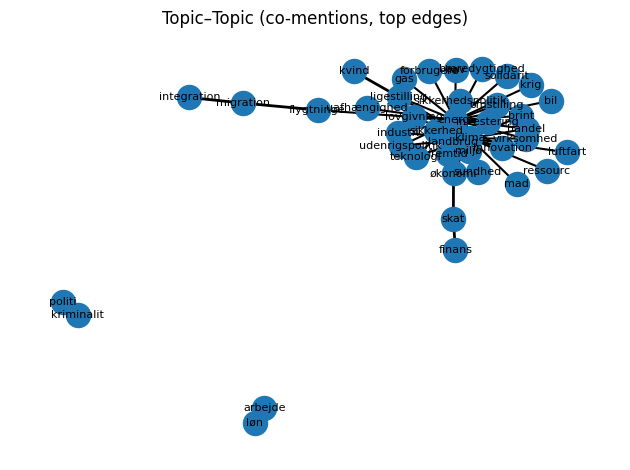

In [102]:
# DENSIFY: Topic–Topic co-occurrence pr. tale (ingen LLM-kald)
import pandas as pd, itertools, networkx as nx, matplotlib.pyplot as plt, os, re

df = pd.read_csv("outputs/triples_normalized.csv")


STOP = {"eu", "union", "marked", "politik"}  
df = df[~df["topic"].isin(STOP)].copy()

# lav co-mentions pr. speech_id
pairs = []
for sid, grp in df.groupby("speech_id"):
    tops = sorted(set(grp["topic"]))
    for a, b in itertools.combinations(tops, 2):
        pairs.append((a, b))

print("Antal rå topic-par:", len(pairs))

if not pairs:
    print("Ingen topic-co-mentions fundet (ingen taler med ≥2 topics efter STOP-filter).")
    
    
    co = pd.DataFrame(columns=["t1", "t2", "weight"])
else:
    
    co = pd.DataFrame(pairs, columns=["t1", "t2"])
    co = co.value_counts().reset_index(name="weight")


# Build Graph
G = nx.Graph()
for _, r in co.iterrows():
    a, b, w = r["t1"], r["t2"], int(r["weight"])
    if G.has_edge(a,b):
        G[a][b]["weight"] += w
    else:
        G.add_edge(a, b, weight=w)

# centralities
deg = nx.degree_centrality(G)
btw = nx.betweenness_centrality(G, weight="weight", normalized=True)
cent = pd.DataFrame({"node": list(deg.keys()),
                     "deg": [deg[n] for n in deg],
                     "betweenness": [btw[n] for n in deg]}).sort_values("deg", ascending=False)

# save
os.makedirs("outputs", exist_ok=True)
co[["t1","t2","weight"]].to_csv("outputs/edgelist_topic_topic.csv", index=False)
cent.to_csv("outputs/centrality_topicproj.csv", index=False)

# plot top edges
E = sorted(G.edges(data=True), key=lambda x: x[2].get("weight",1), reverse=True)[:60]
H = nx.Graph(); [H.add_edge(u,v,**d) for u,v,d in E]
pos = nx.spring_layout(H, seed=42)
plt.figure()
nx.draw_networkx_nodes(H, pos, node_size=300)
nx.draw_networkx_labels(H, pos, font_size=8)
nx.draw_networkx_edges(H, pos, width=[1+d.get("weight",1)*0.5 for _,_,d in H.edges(data=True)])
plt.axis("off"); plt.title("Topic–Topic (co-mentions, top edges)")
plt.tight_layout(); plt.savefig("outputs/top_topics.png", dpi=150)

print("Wrote: edgelist_topic_topic.csv, centrality_topicproj.csv, top_topics.png")



In this step, I add a few simple descriptive checks on the topic–topic network.

The purpose of the code is to:

- Print the total number of rows in the topic dataframe (`df`).
- Show how many unique speeches (`speech_id`) are included.
- Calculate how many speeches contain at least two distinct topics after the stopword filter (these are the speeches that can contribute to co-occurrence edges).
- Print the total number of raw topic pairs generated before aggregation.
- Print the number of unique topic–topic edges in the final co-occurrence table (`co`).

These checks help verify that the network is built on a meaningful amount of data and that enough topic co-occurrences exist to support the analysis.


In [103]:
print("Rows in df:", len(df))
print("Unique speeches (speech_id):", df["speech_id"].nunique())

# how many speeches have ≥2 topics after the STOP filter?
n_topics_pr_tale = df.groupby("speech_id")["topic"].nunique()
print("Speeches with ≥2 topics:", (n_topics_pr_tale >= 2).sum())

print("Number of raw topic pairs:", len(pairs))
print("Number of unique topic-topic edges in the graph:", co.shape[0])


Rows in df: 276
Unique speeches (speech_id): 81
Speeches with ≥2 topics: 81
Number of raw topic pairs: 367
Number of unique topic-topic edges in the graph: 323


## 4.4 Bipartite Speaker–Topic Network + Topic–Topic Projection

In this step, I build the main networks used for analysis and export them as edgelists.

The purpose of the code is to:

- Construct a bipartite graph `B` where:
  - `speaker::<name>` nodes represent speakers,
  - `topic::<word>` nodes represent topics,
  - edges connect speakers to the topics they mention, with edge weights counting how many times a speaker–topic pair occurs.
- Export the bipartite edges (speaker–topic with weights) as `edgelist_bipartite.csv`.
- Identify all topic nodes and create a weighted topic–topic projection `T`, where:
  - nodes are topics,
  - edges connect topics that co-occur via shared speakers, with weights representing co-occurrence strength.
- Export the topic–topic edges as `edgelist_topic_topic.csv`.
- Finally, print the number of nodes in the bipartite graph `B` and in the projected topic graph `T`.

These steps produce the core network structures (speaker–topic and topic–topic) that can be used for further visualization and network analysis.


In [104]:

B = nx.Graph()
for _, r in df_ext.iterrows():
    s = f"speaker::{r['speaker']}"
    t = f"topic::{r['topic']}"
    B.add_node(s, bipartite="speaker", label=r['speaker'])
    B.add_node(t, bipartite="topic", label=r['topic'])
    if B.has_edge(s,t):
        B[s][t]["weight"] += 1
    else:
        B.add_edge(s,t, weight=1)

ed_bi = [(u,v,d["weight"]) for u,v,d in B.edges(data=True)]
pd.DataFrame(ed_bi, columns=["source","target","weight"]).to_csv("outputs/edgelist_bipartite.csv", index=False)

topics = {n for n,d in B.nodes(data=True) if d.get("bipartite")=="topic"}
T = nx.bipartite.weighted_projected_graph(B, topics)

ed_tt = [(u,v,d["weight"]) for u,v,d in T.edges(data=True)]
pd.DataFrame(ed_tt, columns=["source","target","weight"]).to_csv("outputs/edgelist_topic_topic.csv", index=False)

len(B), len(T)


(167, 142)

In this step, I verify that the network analysis results have been saved correctly.

The purpose of the code is to:

- List all files in the `outputs` directory to confirm that the expected result files exist.
- Load `centrality_topicproj.csv` and display the first five rows to quickly inspect the computed centrality measures for the most central topics.

This acts as a final sanity check that the pipeline has run successfully and produced interpretable network outputs.


In [105]:
import os, pandas as pd
print(os.listdir("outputs"))
pd.read_csv("outputs/centrality_topicproj.csv").head(5)


['triples_normalized.csv', 'communities_topicproj.csv', 'top_topics.png', '_raw_llm_debug.csv', 'edgelist_topic_topic.csv', 'triples.csv', 'top_parties.png', 'manual_qa_sample.csv', 'topicproj_topedges.png', 'top_speakers.png', 'centrality_topicproj.csv', 'edgelist_bipartite.csv', 'notebook_toc.csv']


,node,deg,betweenness
0,økonomi,0.217391,0.236015
1,energi,0.195652,0.100289
2,klima,0.188406,0.120755
3,virksomhed,0.152174,0.109695
4,sundhed,0.144928,0.091075


In this step, I build and analyze the speaker–topic network and its topic–topic projection.

The purpose of the code is to:

- Load the extracted triples from `outputs/triples.csv` and check that the file is not empty.
- Normalize topic labels using a simple stemming/canonicalization function (e.g. merging variants like “klimaforandringer” and “klimaindsats” into “klima”) and save the normalized triples to `outputs/triples_normalized.csv`.
- Construct a bipartite NetworkX graph `B` where:
  - `speaker::<name>` nodes represent speakers,
  - `topic::<word>` nodes represent topics,
  - edges connect speakers to the topics they mention, with weights counting how many times the connection occurs.
- Perform sanity checks on the graph (number of nodes, edges, and topic nodes) to ensure the data is valid.
- Create a weighted topic–topic projection `T` from the bipartite graph, where:
  - nodes are topics,
  - edges connect topics that co-occur via shared speakers, weighted by co-occurrence strength.
- Compute degree and betweenness centrality for all topic nodes and save them to `outputs/centrality_topicproj.csv`.
- Visualize the strongest topic–topic connections (top edges) and save the figure as `outputs/topicproj_topedges.png`.

This step turns the LLM-extracted triples into a full network representation and identifies which topics are most central and strongly connected in the debates.


Triples shape: (289, 5)
             speech_id  year            speaker    party        topic
0  2022-11-21 00:00:00  2022  Nikolaj Villumsen  GUE/NGL        sport
1  2022-11-21 00:00:00  2022  Nikolaj Villumsen  GUE/NGL    migration
2  2022-11-21 00:00:00  2022  Nikolaj Villumsen  GUE/NGL  rettigheder
3  2013-03-13 00:00:00  2013     Anne E. Jensen     ALDE       budget
4  2013-03-13 00:00:00  2013     Anne E. Jensen     ALDE    forskning
Nodes in B: 168
Edges in B: 237
Antal topic-noder: 143
Skrev filer i outputs/: ['triples_normalized.csv', 'communities_topicproj.csv', 'top_topics.png', '_raw_llm_debug.csv', 'edgelist_topic_topic.csv', 'triples.csv', 'top_parties.png', 'manual_qa_sample.csv', 'topicproj_topedges.png', 'top_speakers.png', 'centrality_topicproj.csv', 'edgelist_bipartite.csv', 'notebook_toc.csv']


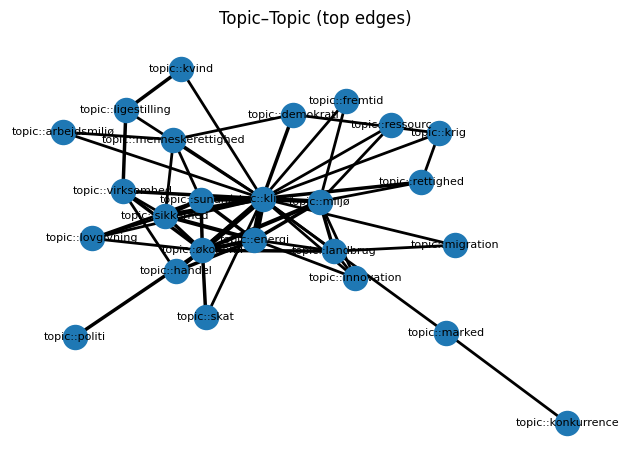

In [106]:
# --- NETVÆRK + FIGUR ---
import os, re, pandas as pd, networkx as nx, matplotlib.pyplot as plt

df = pd.read_csv("outputs/triples.csv")

print("Triples shape:", df.shape)
print(df.head())

if df.empty:
    raise ValueError(
        "outputs/triples.csv er tom – kør LLM-cellen (den med 'Primær OK ...') først, "
        "og tjek at Total rækker > 0."
    )

def norm_topic(t: str) -> str:
    t = str(t).strip().lower()
    t = re.sub(r"(erne|ende|en|et|er)$", "", t)  # meget simpel stemming
    canon = {
        "klimaforandringer":"klima", "klimaindsats":"klima",
        "arbejdspladser":"arbejde", "beskæftigelse":"arbejde",
        "indvandring":"migration", "asyl":"migration"
    }
    return canon.get(t, t)

df["topic"] = df["topic"].map(norm_topic)
df.to_csv("outputs/triples_normalized.csv", index=False)

B = nx.Graph()
for _, r in df.iterrows():
    s = f"speaker::{r['speaker']}"
    t = f"topic::{r['topic']}"
    B.add_node(s, bipartite="speaker", label=r['speaker'])
    B.add_node(t, bipartite="topic", label=r['topic'])
    B.add_edge(s, t, weight=B[s][t]["weight"] + 1 if B.has_edge(s, t) else 1)

print("Nodes in B:", B.number_of_nodes())
print("Edges in B:", B.number_of_edges())

if B.number_of_nodes() == 0:
    raise ValueError("Grafen B er tom – der er ingen gyldige speaker/topic-par at bygge på.")

topics = {n for n, d in B.nodes(data=True) if d.get("bipartite") == "topic"}
print("Antal topic-noder:", len(topics))

if not topics:
    raise ValueError(
        "Mængden 'topics' er tom – tjek at kolonnen 'topic' i triples.csv faktisk indeholder værdier."
    )

T = nx.bipartite.weighted_projected_graph(B, topics)
# ... (resten af din centralitets- og plot-kode)


T = nx.bipartite.weighted_projected_graph(B, topics)
deg = nx.degree_centrality(T)
btw = nx.betweenness_centrality(T, weight="weight", normalized=True)
pd.DataFrame({"node": list(deg.keys()),
              "deg": [deg[n] for n in deg.keys()],
              "betweenness": [btw[n] for n in deg.keys()]}) \
  .sort_values("deg", ascending=False) \
  .to_csv("outputs/centrality_topicproj.csv", index=False)

E = sorted(T.edges(data=True), key=lambda x: x[2].get("weight",1), reverse=True)[:60]
H = nx.Graph(); [H.add_edge(u,v,**d) for u,v,d in E]
pos = nx.spring_layout(H, seed=42)
plt.figure()
nx.draw_networkx_nodes(H, pos, node_size=300)
nx.draw_networkx_labels(H, pos, font_size=8)
nx.draw_networkx_edges(H, pos, width=[1+d.get("weight",1)*0.5 for _,_,d in H.edges(data=True)])
plt.axis("off"); plt.title("Topic–Topic (top edges)")
plt.tight_layout(); plt.savefig("outputs/topicproj_topedges.png", dpi=150)

print("Skrev filer i outputs/:", os.listdir("outputs"))


## 5.1 Descriptive Exploration & QA Sample

In this step, I create basic descriptive statistics and visualizations of the extracted data.

The purpose of the code is to:

- Identify the 15 most frequent:
  - topics (`top_topics`),
  - speakers (`top_speakers`),
  - parties (`top_parties`).
- Plot three bar charts showing:
  - the top topics,
  - the top speakers,
  - the top parties,
  and save the figures as `top_topics.png`, `top_speakers.png`, and `top_parties.png` in the `outputs` folder.
- Draw a small random sample of up to 15 rows from `df_ext` and save it as `manual_qa_sample.csv` for manual inspection of LLM extraction quality.

These descriptive plots and the QA sample help to quickly understand the main patterns in the data and to qualitatively assess how well the LLM extraction works.


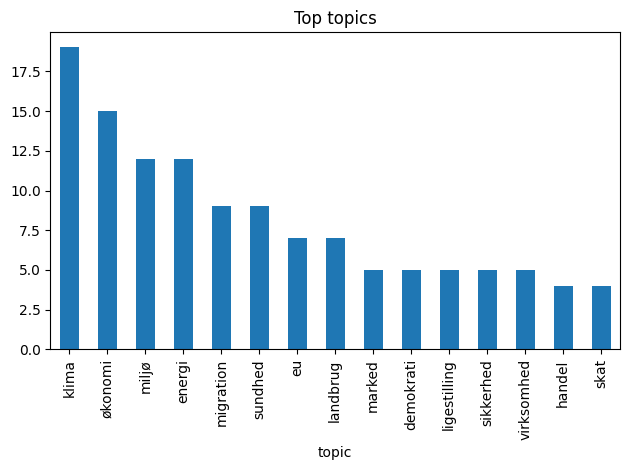

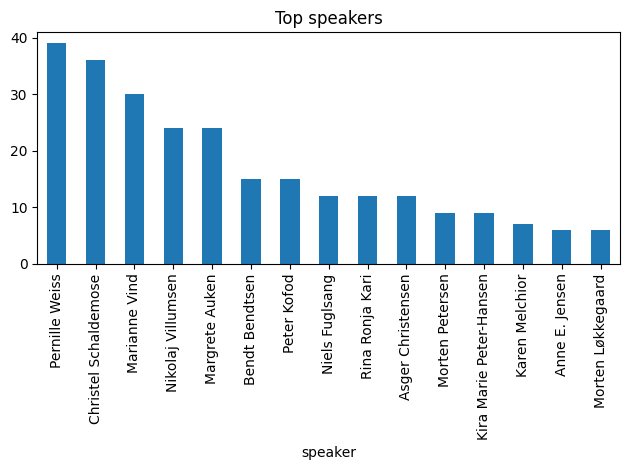

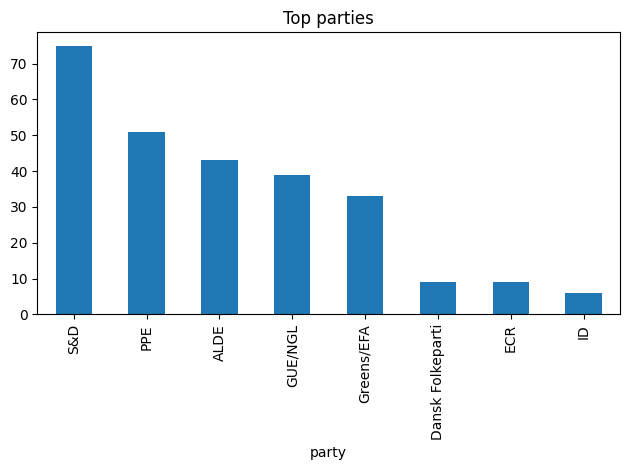

,speech_id,year,speaker,party,topic
252,2022-05-18 00:00:00,2022,Niels Fuglsang,S&D,politik
181,2021-10-05 00:00:00,2021,Pernille Weiss,PPE,krise
187,2020-10-20 00:00:00,2020,Asger Christensen,ALDE,klima


In [107]:

top_topics = df_ext["topic"].value_counts().head(15)
top_speakers = df_ext["speaker"].value_counts().head(15)
top_parties = df_ext["party"].value_counts(dropna=True).head(15)

plt.figure(); top_topics.plot(kind="bar", title="Top topics"); plt.tight_layout(); plt.savefig("outputs/top_topics.png"); plt.show()
plt.figure(); top_speakers.plot(kind="bar", title="Top speakers"); plt.tight_layout(); plt.savefig("outputs/top_speakers.png"); plt.show()
plt.figure(); top_parties.plot(kind="bar", title="Top parties"); plt.tight_layout(); plt.savefig("outputs/top_parties.png"); plt.show()

qa = df_ext.sample(n=min(15, len(df_ext)), random_state=123)
qa.to_csv("outputs/manual_qa_sample.csv", index=False)
qa.head(3)
